This is a VERY complicated Notebook. Linear system of Matrices, etc...

In [92]:
import numpy
from scipy.linalg import solve


In [93]:
def constructMatrix(nx, ny, sigma):
    
    #creates the "A" matrix, implicit type, uses Diriclet in bottom/left and Neumann in top/right
    
    A = numpy.zeros(((nx-2)*(ny-2),(nx-2)*(ny-2)))
    
    row_number = 0 #this is a row counter
    
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            
            #Corners  
            if i==1 and j==1:   #bottom left corner (Dirichlet down/left)
                A[row_number, row_number]= (1/sigma)+4   #Set diagnol
                A[row_number, row_number+1] =  -1        #fetch i+1
                A[row_number, row_number+nx-2] = -1      #fetch j+1
                
            elif i==nx-2 and j==1: #bottom right corner (Dirichlet down, neumann left)
                A[row_number, row_number] =       1/sigma+3   #set diagnol
                A[row_number, row_number-1] =     -1          #fetch i-1
                A[row_number, row_number-(nx-2)]= -1          #fetch j+1
                
            elif i==1 and j==ny-2:   #top left corner (nuemann uup, dirichlet left)
                A[row_number,row_number] = 1/sigma+3   # Set diagonal
                A[row_number,row_number+1] = -1        # fetch i+1
                A[row_number,row_number-(nx-2)] = -1   # fetch j-1

            elif i==nx-2 and j==ny-2: # Top right corner (Neumann up and right)
                A[row_number,row_number] = 1/sigma+2   # Set diagonal
                A[row_number,row_number-1] = -1        # Fetch i-1
                A[row_number,row_number-(nx-2)] = -1   # fetch j-1
            
            #sides
            
            elif i==1: # Left boundary (Dirichlet)
                A[row_number,row_number] = 1/sigma+4 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                A[row_number,row_number-(nx-2)] = -1 # fetch j-1
            
            elif i==nx-2: # Right boundary (Neumann)
                A[row_number,row_number] = 1/sigma+3 # Set diagonal
                A[row_number,row_number-1] = -1      # Fetch i-1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                A[row_number,row_number-(nx-2)] = -1 # fetch j-1
                
            elif j==1: # Bottom boundary (Dirichlet)
                A[row_number,row_number] = 1/sigma+4 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                
            elif j==ny-2: # Top boundary (Neumann)
                A[row_number,row_number] = 1/sigma+3 # Set diagonal
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number-(nx-2)] = -1 # fetch j-1
            
            #interior points
            
            else:
                A[row_number, row_number] = 1/sigma +4
                A[row_number,row_number+1] = -1      # fetch i+1
                A[row_number,row_number-1] = -1      # fetch i-1
                A[row_number,row_number+nx-2] = -1   # fetch j+1
                A[row_number,row_number-(nx-2)] = -1 # fetch j-1
            
            row_number += 1 #Critical line, advances the row number
            
    return A
            

This next code generates the RHS

In [94]:
def generateRHS(nx, ny, sigma, T, T_bc):
        
        RHS = numpy.zeros((nx-2)*(ny-2))
        
        row_number = 0
        
        for j in range(1, ny-1):
            for i in range(1, nx-1):
                 
                # Corners
                if i==1 and j==1: # Bottom left corner (Dirichlet down and left)
                    RHS[row_number] = T[j,i]*1/sigma + 2*T_bc
                
                elif i==nx-2 and j==1: # Bottom right corner (Dirichlet down, Neumann right)
                    RHS[row_number] = T[j,i]*1/sigma + T_bc
                           
                elif i==1 and j==ny-2: # Top left corner (Neumann up, Dirichlet left)
                    RHS[row_number] = T[j,i]*1/sigma + T_bc
                    
                elif i==nx-2 and j==ny-2: # Top right corner (Neumann up and right)
                    RHS[row_number] = T[j,i]*1/sigma 
              
                # Sides
                elif i==1: # Left boundary (Dirichlet)
                    RHS[row_number] = T[j,i]*1/sigma + T_bc
            
                elif i==nx-2: # Right boundary (Neumann)
                    RHS[row_number] = T[j,i]*1/sigma 
                
                elif j==1: # Bottom boundary (Dirichlet)
                    RHS[row_number] = T[j,i]*1/sigma + T_bc
                
                elif j==ny-2: # Top boundary (Neumann)
                    RHS[row_number] = T[j,i]*1/sigma
                
                #Interior points
            
                else:
                    RHS[row_number] = T[j,i]*1/sigma
                
                row_number += 1 
    
        return RHS
                
                

This next function needs to take the 2D T n+1 values and put it in a 2D array that matches the physical domain

In [95]:
def map_1Dto2D(nx, ny, T_1D, T_bc):
    """ Takes temperatures of solution of linear system, stored in 1D, 
    and puts them in a 2D array with the BCs
    Valid for constant Dirichlet bottom and left, and Neumann with zero 
    flux top and right
    """
    T = numpy.zeros((ny,nx))
    
    row_number = 0
    
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            
            T[j,i] = T_1D[row_number]
            row_number += 1
            
    #Dirichlet BC
    T[0,:] = T_bc
    T[:,0] = T_bc
    
    #Nuemann BC
    
    T[-1,:] = T[-2,:]
    T[:,-1] = T[:,-2]
    
    return T
            
            
    

*sigh, this next code advacnces us in time

In [96]:
def btcs_2D(T, A, nt, sigma, T_bc, nx, ny, dt):
    
    j_mid = (numpy.shape(T)[0])/2
    i_mid = (numpy.shape(T)[1])/2
    
    for t in range(nt):
        
        Tn=T.copy()
        
        b = generateRHS(nx, ny, sigma, Tn, T_bc)
        
        T_interior = solve(A,b) #using numpy.linalg.solve
        
        T = map_1Dto2D(nx, ny, T_interior, T_bc)
        
        #check if we reached T=70
    
        if T[j_mid, i_mid] >= 70:
            print ("Center of plate reached 70C at time {0:.2f}s, in time step {1:d}.".format(dt*t, t))
            break
            
    if T[j_mid, i_mid]<70:
        print ("Center has not reached 70C yet, it is only {0:.2f}C.".format(T[j_mid, i_mid]))       
        
    return T

In [97]:
alpha = 1e-4

L = 1.0e-2
H = 1.0e-2

nx = 21
ny = 21
nt = 300

dx = L/(nx-1)
dy = H/(ny-1)

x = numpy.linspace(0,L,nx)
y = numpy.linspace(0,H,ny)

T_bc = 100

Ti = numpy.ones((ny, nx))*20
Ti[0,:]= T_bc
Ti[:,0] = T_bc

In [98]:
sigma = 0.25
A = constructMatrix(nx, ny, sigma)

In [99]:
print(A)

[[ 8. -1.  0. ...,  0.  0.  0.]
 [-1.  8. -1. ...,  0.  0.  0.]
 [ 0. -1.  8. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  7. -1.  0.]
 [ 0.  0.  0. ..., -1.  7. -1.]
 [ 0.  0.  0. ...,  0. -1.  6.]]


In [100]:
dt = sigma * min(dx, dy)**2 / alpha
T = btcs_2D(Ti.copy(), A, nt, sigma, T_bc, nx, ny, dt)

C:\Users\ctiu\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\ctiu\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Center of plate reached 70C at time 0.16s, in time step 263.


In [101]:
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

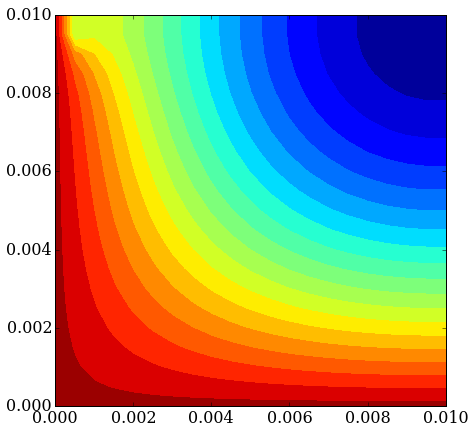

In [102]:
mx, my = numpy.meshgrid(x, y)
pyplot.figure(figsize=(7,7))
pyplot.contourf(my,mx,T,20);

hmmm, my answer is a bit different, wonder what I accidently changed...